<a href="https://colab.research.google.com/github/RomanTomz/Covid_19Italia-Data-Viz/blob/master/covid19_ita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import date


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from fbprophet.plot import plot_plotly
import plotly.offline as py
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')


from google.colab import drive
from google.colab import files
import json
import requests
from fbprophet import Prophet

drive.mount('/content/drive')

%load_ext google.colab.data_table


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Provincie Analysis

In [2]:
df_p = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json')
df_p

data stato  codice_regione  ... totale_casi  note_it note_en
0     2020-02-24T18:00:00   ITA              13  ...           0                 
1     2020-02-24T18:00:00   ITA              13  ...           0                 
2     2020-02-24T18:00:00   ITA              13  ...           0                 
3     2020-02-24T18:00:00   ITA              13  ...           0                 
4     2020-02-24T18:00:00   ITA              13  ...           0                 
...                   ...   ...             ...  ...         ...      ...     ...
9211  2020-05-05T17:00:00   ITA               5  ...        2560                 
9212  2020-05-05T17:00:00   ITA               5  ...        2519                 
9213  2020-05-05T17:00:00   ITA               5  ...        4831                 
9214  2020-05-05T17:00:00   ITA               5  ...        2722                 
9215  2020-05-05T17:00:00   ITA               5  ...         325                 

[9216 rows x 12 columns]

In [0]:
df_p.data = pd.to_datetime(df_p.data)

In [4]:
# Data from Lombardia provinces

lom_p =  df_p[df_p.denominazione_regione == 'Lombardia']
lom_p.reset_index(drop=True, inplace=True)
lom_p.data = lom_p.data.dt.date

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
lom_p.head()

data stato  codice_regione  ... totale_casi  note_it note_en
0  2020-02-24   ITA               3  ...           0                 
1  2020-02-24   ITA               3  ...           0                 
2  2020-02-24   ITA               3  ...           0                 
3  2020-02-24   ITA               3  ...           0                 
4  2020-02-24   ITA               3  ...           0                 

[5 rows x 12 columns]

In [0]:
# DF with regional&province data

polenta_p = df_p[(df_p.denominazione_regione == 'Lombardia') | (df_p.denominazione_regione == 'Veneto') | (df_p.denominazione_regione == 'Emilia Romagna') | (df_p.denominazione_regione == 'Piemonte')]

In [0]:
lom_pc = lom_p[~(lom_p.denominazione_provincia == 'In fase di definizione/aggiornamento')]

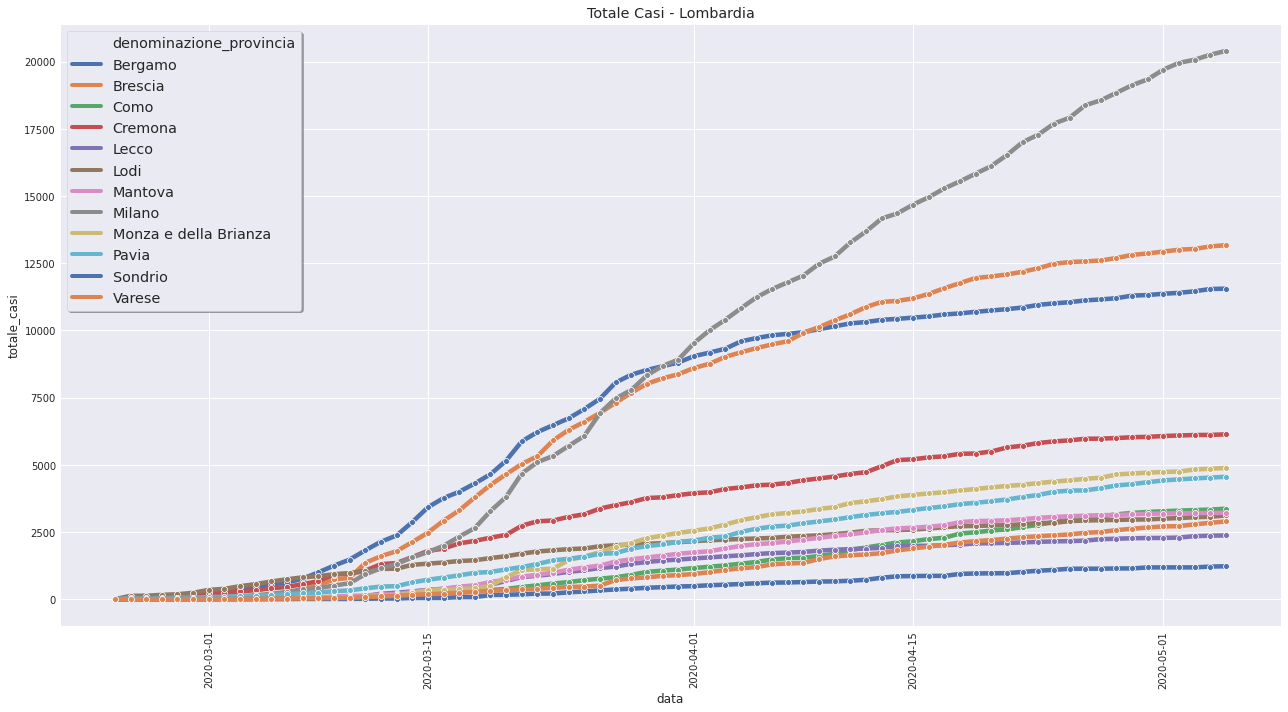

In [8]:
plt.figure(figsize=(18,10))

plt.title('Totale Casi - Lombardia')
sns.lineplot(data=lom_pc, x=lom_pc['data'], y='totale_casi', palette='deep', hue='denominazione_provincia', lw=4.5, n_boot=0, marker='8')
plt.legend(shadow=True, fontsize='x-large')
plt.xticks(rotation=90)
plt.tight_layout()

In [9]:
px.line(lom_pc, x=lom_pc['data'],y='totale_casi',line_group='denominazione_provincia', color='denominazione_provincia', log_y=False, line_shape='linear')

In [10]:
df_p.head(2)

data stato  codice_regione  ... totale_casi  note_it note_en
0 2020-02-24 18:00:00   ITA              13  ...           0                 
1 2020-02-24 18:00:00   ITA              13  ...           0                 

[2 rows x 12 columns]

In [0]:
df_p['pct_crescita'] = df_p.groupby('denominazione_provincia')['totale_casi'].transform(lambda x: (x.pct_change()*100).round(1))

In [0]:
df_pc = df_p[~(df_p.denominazione_provincia == 'In fase di definizione/aggiornamento')]
df_pc.set_index('data', inplace=True)

In [13]:
prov_latest =  df_pc.sort_index().groupby('denominazione_provincia').tail(1)
prov_latest.head()

stato  codice_regione  ... note_en  pct_crescita
data                                       ...                      
2020-05-05 17:00:00   ITA              13  ...                   0.1
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              13  ...                   1.8
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              17  ...                   1.0

[5 rows x 12 columns]

In [14]:
prov_latest.sort_values(by='pct_crescita', ascending=False).tail(20)

stato  codice_regione  ... note_en  pct_crescita
data                                       ...                      
2020-05-05 17:00:00   ITA              15  ...                   0.0
2020-05-05 17:00:00   ITA              16  ...                   0.0
2020-05-05 17:00:00   ITA               6  ...                   0.0
2020-05-05 17:00:00   ITA              16  ...                   0.0
2020-05-05 17:00:00   ITA              14  ...                   0.0
2020-05-05 17:00:00   ITA              14  ...                   0.0
2020-05-05 17:00:00   ITA              16  ...                   0.0
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              20  ...                   0.0
2020-05-05 17:00:00   ITA              20  ...                   0.0
2020-05-05 17:00:00   ITA              20  ...                   0.0
2020-05-05 17:00:00   ITA              20  ...                   0.0
2020-05-05 17:00:00   ITA              19  ...                   0.0
2020-05-05 17:00:00   ITA              19  ...                   0.0
2020-05-05 17:00:00   ITA              19  ...                   0.0
2020-05-05 17:00:00   ITA               7  ...                   0.0
2020-05-05 17:00:00   ITA              19  ...                   0.0
2020-05-05 17:00:00   ITA               6  ...                   0.0
2020-05-05 17:00:00   ITA               5  ...                  -0.2
2020-05-05 17:00:00   ITA              12  ...                  -0.2

[20 rows x 12 columns]

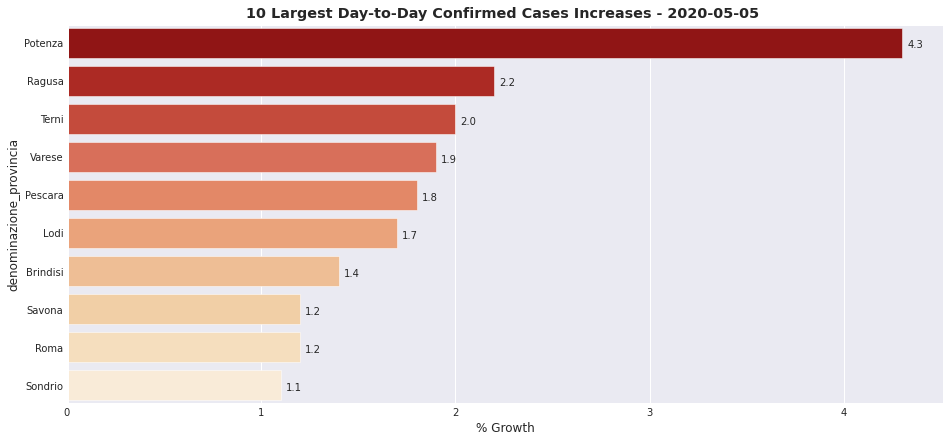

In [15]:
plt.figure(figsize=(14,7))
plt.title(f'10 Largest Day-to-Day Confirmed Cases Increases - {date.today()} ', fontweight='bold')
ax=sns.barplot(data=prov_latest.sort_values(by='pct_crescita', ascending=False).head(10), x='pct_crescita', y='denominazione_provincia', palette='OrRd_r')
plt.xlabel('% Growth')
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.8),
                xytext=(5, 10), textcoords='offset points')

In [16]:
prov_latest.sort_values(by='pct_crescita', ascending=False)

stato  codice_regione  ... note_en  pct_crescita
data                                       ...                      
2020-05-05 17:00:00   ITA              17  ...                   4.3
2020-05-05 17:00:00   ITA              19  ...                   2.2
2020-05-05 17:00:00   ITA              10  ...                   2.0
2020-05-05 17:00:00   ITA               3  ...                   1.9
2020-05-05 17:00:00   ITA              13  ...                   1.8
...                   ...             ...  ...     ...           ...
2020-05-05 17:00:00   ITA               7  ...                   0.0
2020-05-05 17:00:00   ITA              19  ...                   0.0
2020-05-05 17:00:00   ITA               6  ...                   0.0
2020-05-05 17:00:00   ITA               5  ...                  -0.2
2020-05-05 17:00:00   ITA              12  ...                  -0.2

[107 rows x 12 columns]

### Analysis by region

In [17]:
regioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=True, index_col='data')
regioni.head()

stato  codice_regione  ... note_it  note_en
data                                       ...                 
2020-02-24 18:00:00   ITA              13  ...     NaN      NaN
2020-02-24 18:00:00   ITA              17  ...     NaN      NaN
2020-02-24 18:00:00   ITA               4  ...     NaN      NaN
2020-02-24 18:00:00   ITA              18  ...     NaN      NaN
2020-02-24 18:00:00   ITA              15  ...     NaN      NaN

[5 rows x 19 columns]

In [0]:
regioni['nuovi_tamponi'] = regioni.groupby('denominazione_regione')['tamponi'].transform(lambda x: x.diff())
regioni['nuovi_deceduti'] = regioni.groupby('denominazione_regione')['deceduti'].transform(lambda x: x.diff())
regioni['pct_nuovi_pos'] = regioni.groupby('denominazione_regione')['totale_positivi'].transform(lambda x: (x.pct_change()*100).round(1))

In [19]:
# filtering for latest timestamp

reg_latest = regioni.sort_index().groupby('denominazione_regione').tail(1)
reg_latest.head()

stato  codice_regione  ... nuovi_deceduti  pct_nuovi_pos
data                                       ...                              
2020-05-05 17:00:00   ITA              13  ...            3.0           -1.5
2020-05-05 17:00:00   ITA              17  ...            0.0            2.3
2020-05-05 17:00:00   ITA               4  ...            2.0           -3.8
2020-05-05 17:00:00   ITA              18  ...            0.0           -3.6
2020-05-05 17:00:00   ITA              15  ...            3.0           -6.7

[5 rows x 22 columns]

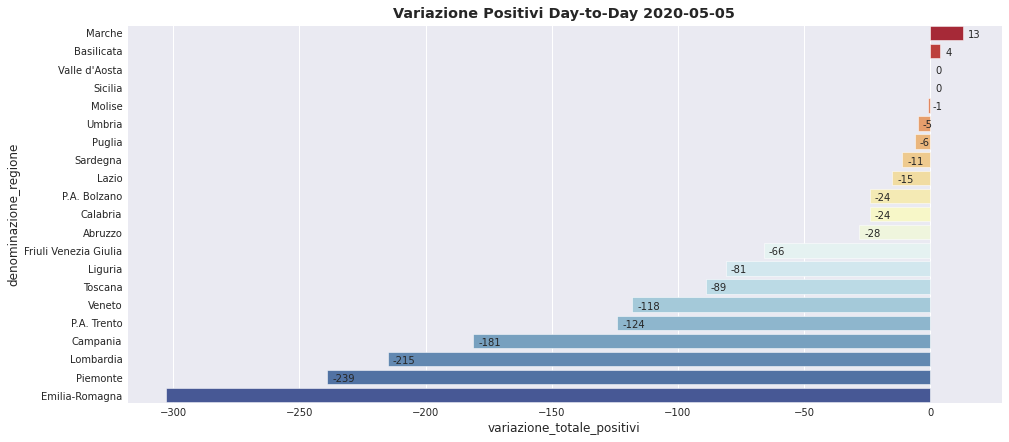

In [20]:
reg_latest.sort_values(by='variazione_totale_positivi', ascending=False, inplace=True)
plt.figure(figsize=(14,7))
plt.title(f'Variazione Positivi Day-to-Day {date.today()}', fontweight='bold')
ax=sns.barplot(data=reg_latest, x='variazione_totale_positivi', palette='RdYlBu', y=reg_latest.denominazione_regione)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

In [0]:
regioni.reset_index(inplace=True)

### Subtotals plots

In [22]:
subtotal_reg = regioni.groupby('data')['variazione_totale_positivi','nuovi_tamponi','nuovi_deceduti', 'totale_casi', 'deceduti', 'nuovi_positivi','casi_testati'].sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [0]:
subtotal_reg['pct_tamp_pos'] = ((subtotal_reg.nuovi_positivi/subtotal_reg.nuovi_tamponi)*100).round(2)

In [0]:
subtotal_reg.index = pd.to_datetime(subtotal_reg.index, format='%d/%m/%Y')
subtotal_reg.index = subtotal_reg.index.normalize()

In [0]:
subtotal_reg['pct_crescita'] = (subtotal_reg.totale_casi.pct_change()*100).round(2)

In [0]:
subtotal_reg['pct_deceduti'] = (subtotal_reg.deceduti.pct_change()*100).round(2)

In [27]:
subtotal_reg.head()

variazione_totale_positivi  ...  pct_deceduti
data                                    ...              
2020-02-24                           0  ...           NaN
2020-02-25                          90  ...         42.86
2020-02-26                          74  ...         20.00
2020-02-27                         203  ...         41.67
2020-02-28                         233  ...         23.53

[5 rows x 10 columns]

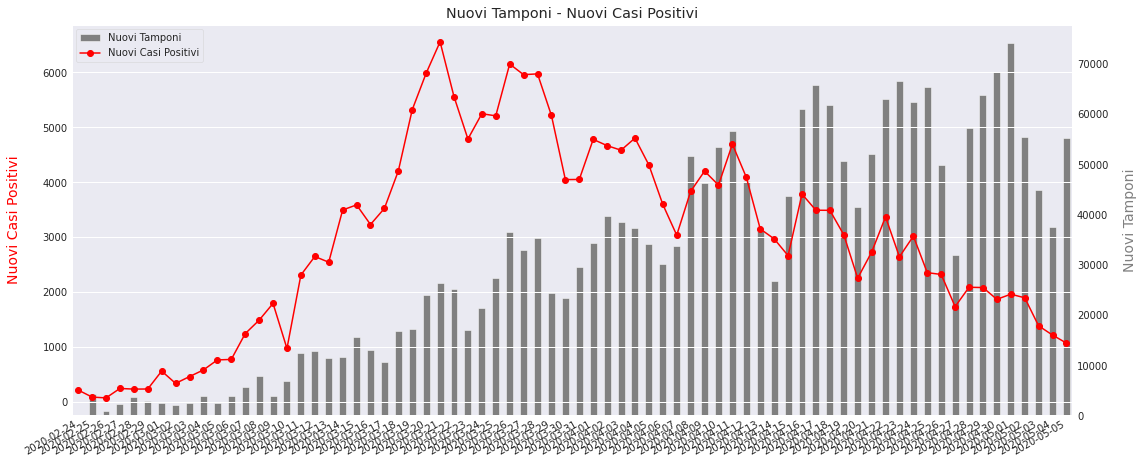

In [28]:
subtotal_reg.index = subtotal_reg.index.date
fig, ax = plt.subplots(figsize=(16,8))
subtotal_reg.nuovi_tamponi.plot(kind='bar', stacked=False, title='Nuovi Tamponi - Nuovi Casi Positivi', 
                           color='grey', ax=ax, grid=False, label='Nuovi Tamponi')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), subtotal_reg.nuovi_positivi.values, linestyle='-', marker='o', 
        color='r', linewidth=1.5, label='Nuovi Casi Positivi')
plt.xticks(rotation=40)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.set_ylabel('Nuovi Casi Positivi', fontsize=14, color='red', labelpad=50)
ax2.set_ylabel('Nuovi Tamponi', fontsize=14, color='grey', labelpad=50)
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")


fig.autofmt_xdate()
plt.show()

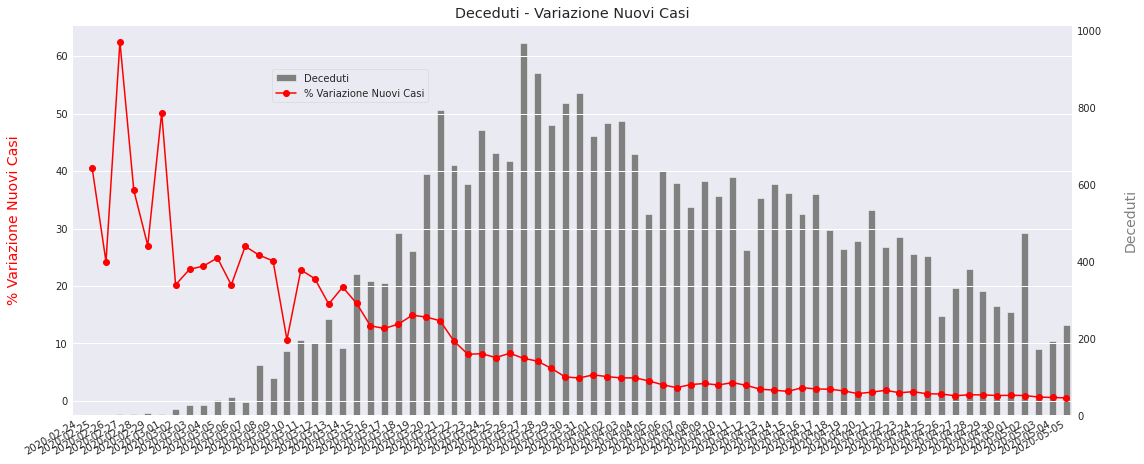

In [29]:


fig, ax = plt.subplots(figsize=(16,8))
subtotal_reg.nuovi_deceduti.plot(kind='bar', stacked=False, title='Deceduti - Variazione Nuovi Casi', 
                           color='grey', ax=ax, grid=False, label='Deceduti')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), subtotal_reg.pct_crescita, linestyle='-', marker='o', 
        color='r', linewidth=1.5, label='% Variazione Nuovi Casi')
plt.xticks(rotation=90)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=(0.2,0.8))
ax.set_ylabel('% Variazione Nuovi Casi', fontsize=14, color='red', labelpad=50)
ax2.set_ylabel('Deceduti', fontsize=14, color='grey', labelpad=50)
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")


fig.autofmt_xdate()
plt.show()

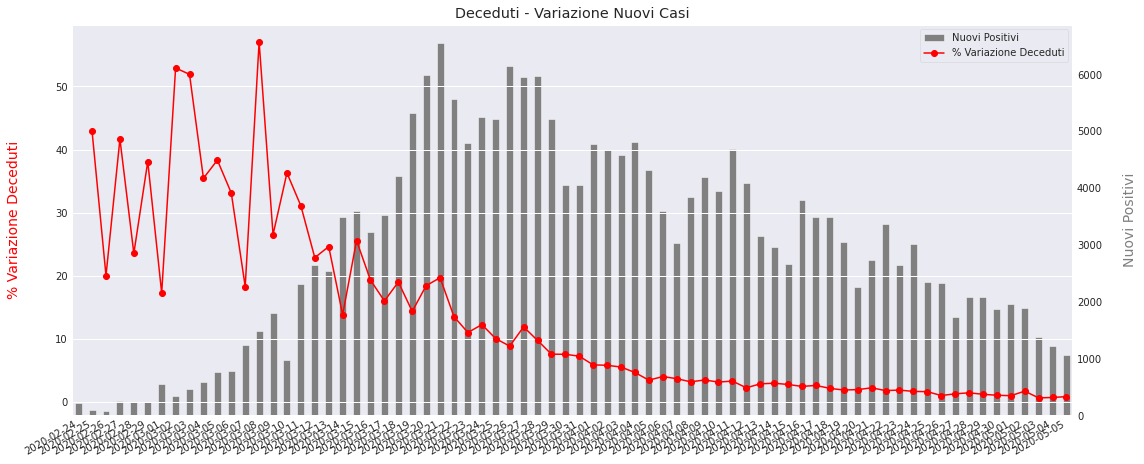

In [30]:

fig, ax = plt.subplots(figsize=(16,8))
subtotal_reg.nuovi_positivi.plot(kind='bar', stacked=False, title='Deceduti - Variazione Nuovi Casi', 
                           color='grey', ax=ax, grid=False, label='Nuovi Positivi')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), subtotal_reg.pct_deceduti, linestyle='-', marker='o', 
        color='r', linewidth=1.5, label='% Variazione Deceduti')
plt.xticks(rotation=90)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.set_ylabel('% Variazione Deceduti', fontsize=14, color='red', labelpad=50)
ax2.set_ylabel('Nuovi Positivi', fontsize=14, color='grey', labelpad=50)
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")


fig.autofmt_xdate()
plt.show()

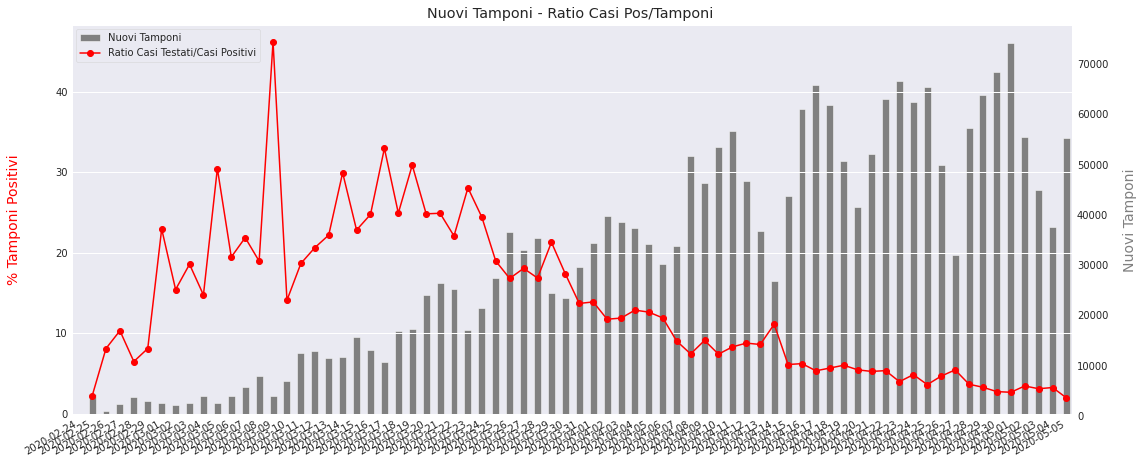

In [31]:

fig, ax = plt.subplots(figsize=(16,8))
subtotal_reg.nuovi_tamponi.plot(kind='bar', stacked=False, title='Nuovi Tamponi - Ratio Casi Pos/Tamponi ', 
                           color='grey', ax=ax, grid=False, label='Nuovi Tamponi')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), subtotal_reg.pct_tamp_pos.values, linestyle='-', marker='o', 
        color='r', linewidth=1.5, label='Ratio Casi Testati/Casi Positivi')
plt.xticks(rotation=90)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.set_ylabel('% Tamponi Positivi', fontsize=14, color='red', labelpad=50)
ax2.set_ylabel('Nuovi Tamponi', fontsize=14, color='grey', labelpad=50)
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")


fig.autofmt_xdate()
plt.show()

### Analysis of Testing (Tamponi)

In [0]:
regioni.set_index('data',inplace=True)
lombardia = regioni[regioni.denominazione_regione == 'Lombardia']
lombardia.index = lombardia.index.date

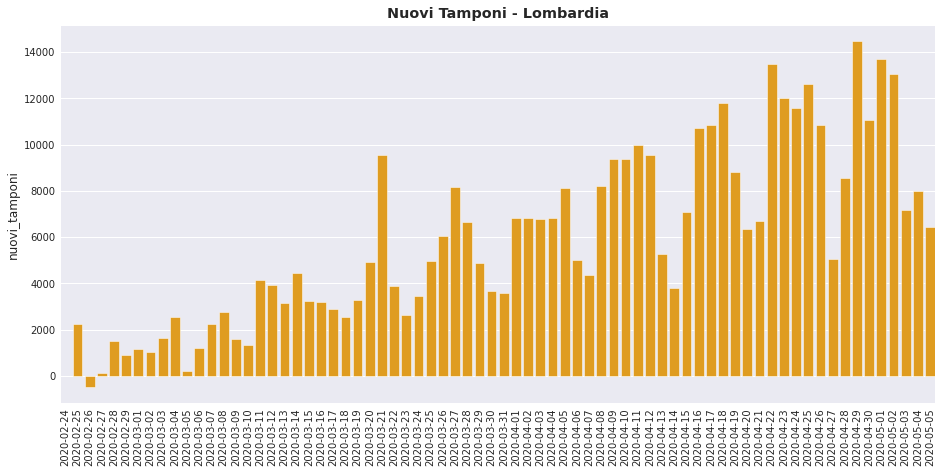

In [33]:
# New daily tests (Lombardia)

plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.title('Nuovi Tamponi - Lombardia', fontweight='bold')
sns.barplot(data=lombardia, x=lombardia.index, y='nuovi_tamponi', color='orange')


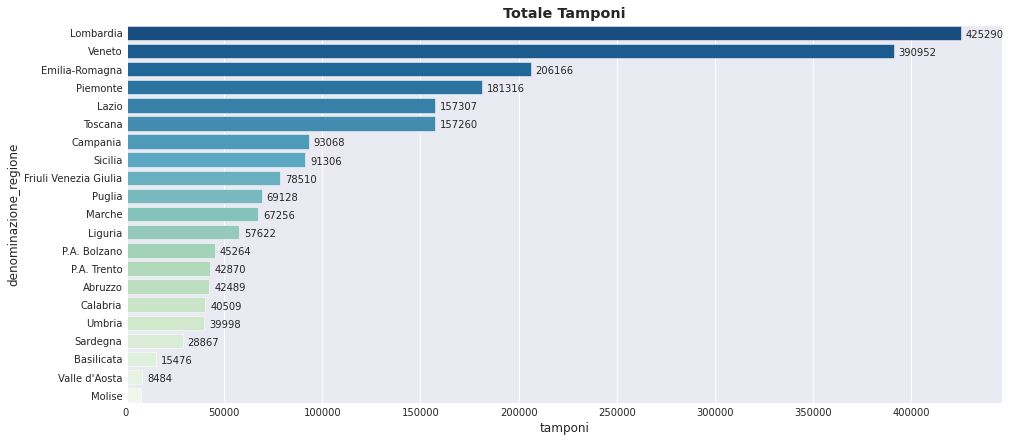

In [34]:
# Total tests carried out by region

reg_latest.sort_values(by='tamponi', ascending=False,inplace=True)
plt.figure(figsize=(14,7))
plt.title('Totale Tamponi', fontweight='bold')
ax=sns.barplot(data=reg_latest, x=reg_latest['tamponi'].astype(int), y=reg_latest.denominazione_regione, palette='GnBu_r')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

In [35]:
pop = pd.read_html('https://www.tuttitalia.it/regioni/popolazione/', encoding='utf-8')
popdf = pd.DataFrame(pop[0])
popdf = popdf[['Regione','Popolazioneresidenti', popdf.columns[4]]]
popdf.set_index('Regione', inplace=True)
popdf

Popolazioneresidenti  Densitàabitanti/km²
Regione                                                        
Lombardia                       10.060.574                  422
Lazio                            5.879.082                  341
Campania                         5.801.692                  424
Sicilia                          4.999.891                  194
Veneto                           4.905.854                  267
Emilia-Romagna                   4.459.477                  199
Piemonte                         4.356.406                  172
Puglia                           4.029.053                  206
Toscana                          3.729.641                  162
Calabria                         1.947.131                  128
Sardegna                         1.639.591                   68
Liguria                          1.550.640                  286
Marche                           1.525.271                  162
Abruzzo                          1.311.580                  121
Friuli Venezia Giulia            1.215.220                  153
Trentino-Alto Adige              1.072.276                   79
Umbria                             882.015                  104
Basilicata                         562.869                   56
Molise                             305.617                   69
Valle d'Aosta                      125.666                   39
Totale                          60.359.546                  200

In [0]:
popdf.rename(columns={list(popdf)[1]:'densita'}, inplace=True)

In [37]:
reg_merged = reg_latest.merge(right=popdf, how='left', left_on=reg_latest.denominazione_regione, right_on=popdf.index)
reg_merged.rename(columns={'key_0':'Regione'}, inplace=True)
reg_merged.set_index('Regione', drop=True, inplace=True)
reg_merged

stato  codice_regione  ... Popolazioneresidenti  densita
Regione                                      ...                              
Lombardia               ITA               3  ...           10.060.574    422.0
Veneto                  ITA               5  ...            4.905.854    267.0
Emilia-Romagna          ITA               8  ...            4.459.477    199.0
Piemonte                ITA               1  ...            4.356.406    172.0
Lazio                   ITA              12  ...            5.879.082    341.0
Toscana                 ITA               9  ...            3.729.641    162.0
Campania                ITA              15  ...            5.801.692    424.0
Sicilia                 ITA              19  ...            4.999.891    194.0
Friuli Venezia Giulia   ITA               6  ...            1.215.220    153.0
Puglia                  ITA              16  ...            4.029.053    206.0
Marche                  ITA              11  ...            1.525.271    162.0
Liguria                 ITA               7  ...            1.550.640    286.0
P.A. Bolzano            ITA               4  ...                  NaN      NaN
P.A. Trento             ITA               4  ...                  NaN      NaN
Abruzzo                 ITA              13  ...            1.311.580    121.0
Calabria                ITA              18  ...            1.947.131    128.0
Umbria                  ITA              10  ...              882.015    104.0
Sardegna                ITA              20  ...            1.639.591     68.0
Basilicata              ITA              17  ...              562.869     56.0
Valle d'Aosta           ITA               2  ...              125.666     39.0
Molise                  ITA              14  ...              305.617     69.0

[21 rows x 24 columns]

In [0]:
# Drop P.A. Bolzano & P.A. Trento due to inconsistency with the region format (They are a province rather than a region)
# Drop "note" columns
# Column Popolazioneresidenti has dtype string. Need to remove "." and convert to_numeric

#reg_merged.drop([reg_merged.index[16], reg_merged.index[11]], inplace=True)
reg_merged.dropna(how='all', axis=1, inplace=True)
reg_merged.Popolazioneresidenti = pd.to_numeric(reg_merged.Popolazioneresidenti.str.replace('.',''))

In [39]:
reg_merged.index == 'Liguria'

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False])

In [40]:
reg_merged.nuovi_tamponi.sum()

55263.0

In [0]:
 reg_merged['Tamponi_x_1000_Abitanti'] = ((reg_merged.tamponi/reg_merged.Popolazioneresidenti)*1000).round(1)

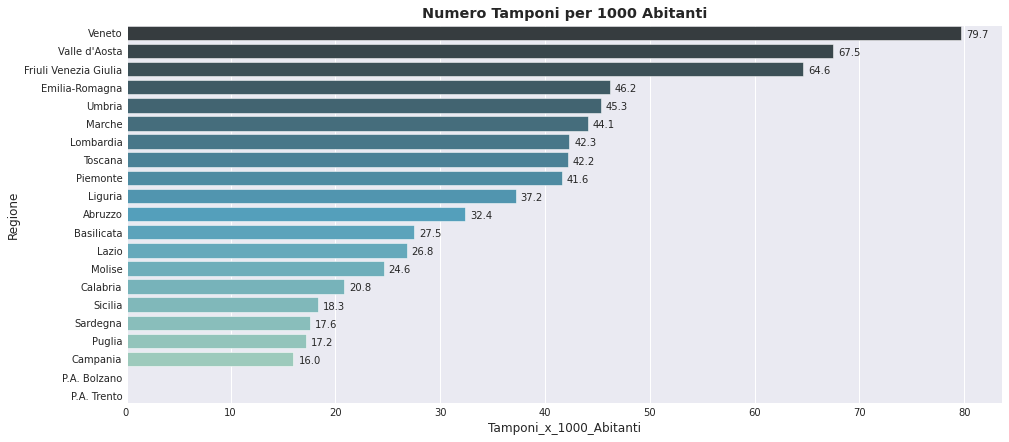

In [42]:
reg_merged.sort_values(by='Tamponi_x_1000_Abitanti', ascending=False, inplace=True)
plt.figure(figsize=(14,7))
plt.title('Numero Tamponi per 1000 Abitanti', fontweight='bold')
ax=sns.barplot(data=reg_merged, x='Tamponi_x_1000_Abitanti', y=reg_merged.index, palette='GnBu_d')
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

In [43]:
reg_merged.head()

stato  codice_regione  ... densita  Tamponi_x_1000_Abitanti
Regione                                      ...                                 
Veneto                  ITA               5  ...   267.0                     79.7
Valle d'Aosta           ITA               2  ...    39.0                     67.5
Friuli Venezia Giulia   ITA               6  ...   153.0                     64.6
Emilia-Romagna          ITA               8  ...   199.0                     46.2
Umbria                  ITA              10  ...   104.0                     45.3

[5 rows x 23 columns]

So far I have:
1. regioni: df with all the original data and datetime index
2. reg_latest: df with the data from the latest timestamp
3. reg_merged: reg_latest with population and density data




In [44]:
regioni.head(3)

stato  codice_regione  ... nuovi_deceduti  pct_nuovi_pos
data                                       ...                              
2020-02-24 18:00:00   ITA              13  ...            NaN            NaN
2020-02-24 18:00:00   ITA              17  ...            NaN            NaN
2020-02-24 18:00:00   ITA               4  ...            NaN            NaN

[3 rows x 22 columns]

In [0]:
reg_merged['nuovi_contagiati_nuovi_tamponi'] = (reg_merged.nuovi_positivi/reg_merged.nuovi_tamponi)*100

In [46]:
reg_merged.head(2)

stato  ...  nuovi_contagiati_nuovi_tamponi
Regione              ...                                
Veneto          ITA  ...                        0.397696
Valle d'Aosta   ITA  ...                        0.000000

[2 rows x 24 columns]

In [0]:
reg_merged['nuovi_tamponi_x_1000'] = (reg_merged.nuovi_tamponi/reg_merged.Popolazioneresidenti)*1000


In [48]:
reg_merged.head(2)

stato  ...  nuovi_tamponi_x_1000
Regione              ...                      
Veneto          ITA  ...              1.486387
Valle d'Aosta   ITA  ...              1.694969

[2 rows x 25 columns]

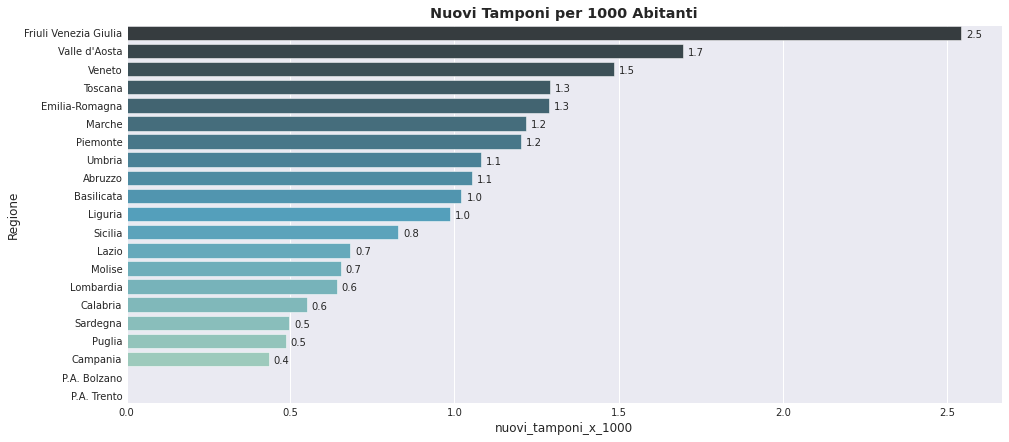

In [49]:
reg_merged.sort_values(by='nuovi_tamponi_x_1000', ascending=False, inplace=True)
plt.figure(figsize=(14,7))
plt.title('Nuovi Tamponi per 1000 Abitanti', fontweight='bold')
ax=sns.barplot(data=reg_merged, x='nuovi_tamponi_x_1000', y=reg_merged.index, palette='GnBu_d')
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

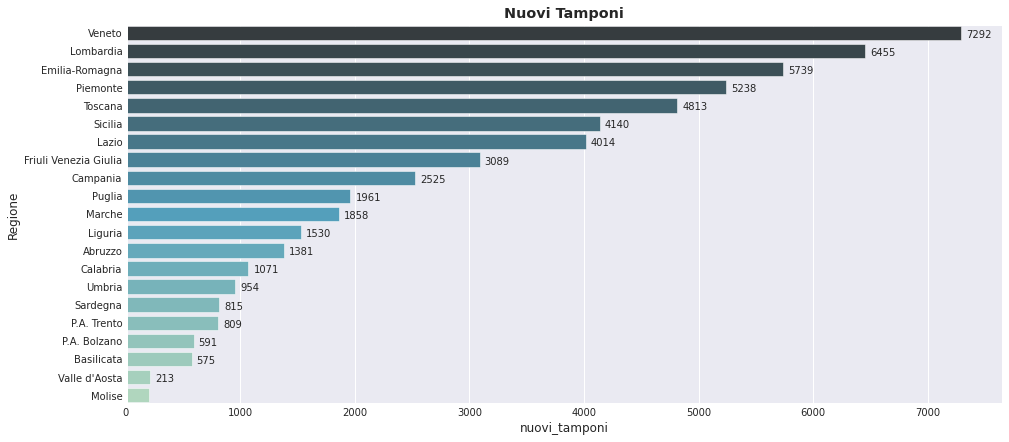

In [50]:
reg_merged.sort_values(by='nuovi_tamponi', ascending=False, inplace=True)
plt.figure(figsize=(14,7))
plt.title('Nuovi Tamponi', fontweight='bold')
ax=sns.barplot(data=reg_merged, x='nuovi_tamponi', y=reg_merged.index, palette='GnBu_d')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

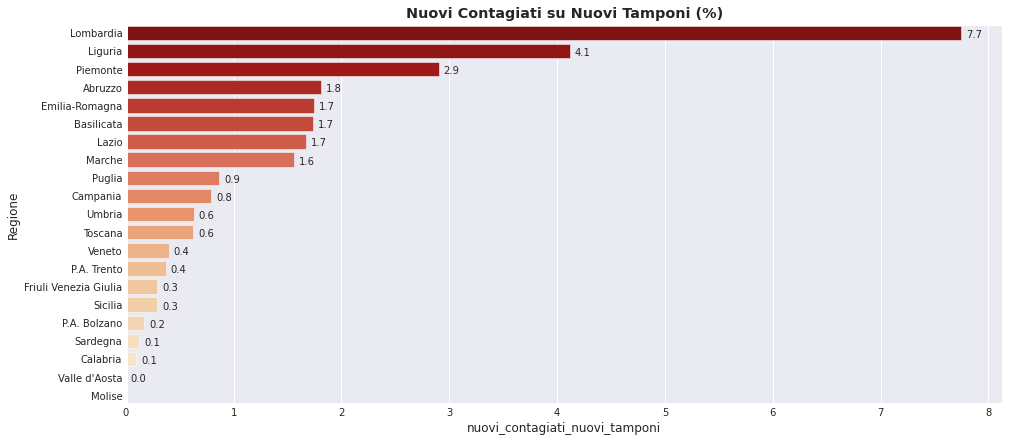

In [51]:
reg_merged.sort_values(by='nuovi_contagiati_nuovi_tamponi', ascending=False, inplace=True)
plt.figure(figsize=(14,7))
plt.title('Nuovi Contagiati su Nuovi Tamponi (%)', fontweight='bold')
ax=sns.barplot(data=reg_merged, x='nuovi_contagiati_nuovi_tamponi', y=reg_merged.index, palette='OrRd_r')
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

In [52]:
reg_merged.nuovi_tamponi.sum()

55263.0

### Hospitalisations and ICU data

In [53]:
regioni.head()

stato  codice_regione  ... nuovi_deceduti  pct_nuovi_pos
data                                       ...                              
2020-02-24 18:00:00   ITA              13  ...            NaN            NaN
2020-02-24 18:00:00   ITA              17  ...            NaN            NaN
2020-02-24 18:00:00   ITA               4  ...            NaN            NaN
2020-02-24 18:00:00   ITA              18  ...            NaN            NaN
2020-02-24 18:00:00   ITA              15  ...            NaN            NaN

[5 rows x 22 columns]

In [0]:
# Obtaining deltas in hospitalisation and home-isolation quantities. Adding columns to Regioni


regioni['delta_osp'] = regioni.groupby('denominazione_regione')['totale_ospedalizzati'].transform(lambda x: x.diff())
regioni['delta_ti'] = regioni.groupby('denominazione_regione')['terapia_intensiva'].transform(lambda x: x.diff())
regioni['delta_iso'] = regioni.groupby('denominazione_regione')['isolamento_domiciliare'].transform(lambda x: x.diff())

In [0]:
regioni.reset_index(inplace=True)

In [0]:
regioni_mi = regioni.set_index(['data','denominazione_regione'])

In [57]:
reg_latest = regioni_mi.loc[[regioni_mi.index.get_level_values(0)[-1]]]
reg_latest.head()

stato  ...  delta_iso
data                denominazione_regione        ...           
2020-05-05 17:00:00 Abruzzo                 ITA  ...      -12.0
                    Basilicata              ITA  ...        4.0
                    P.A. Bolzano            ITA  ...      -21.0
                    Calabria                ITA  ...      -23.0
                    Campania                ITA  ...     -152.0

[5 rows x 24 columns]

In [58]:
reg_latest['dummy_osp'] = reg_latest['delta_osp'] > 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



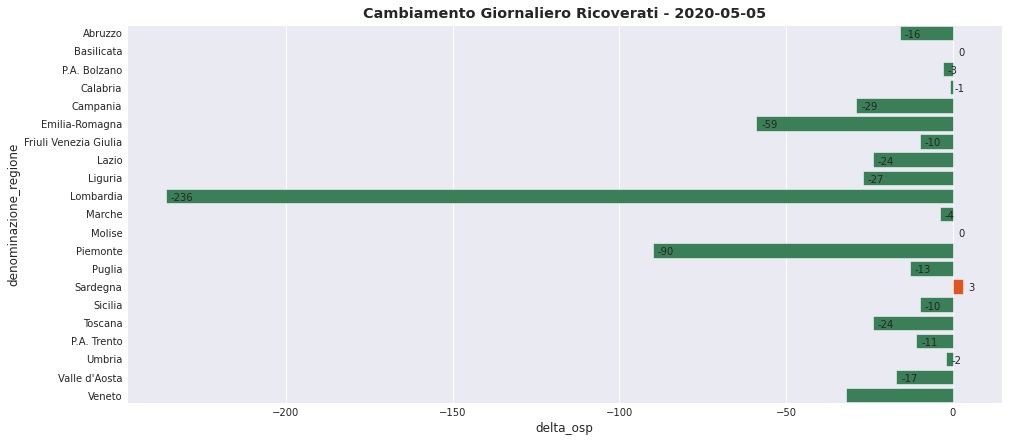

In [59]:
plt.figure(figsize=(14,7))
plt.title(f'Cambiamento Giornaliero Ricoverati - {date.today()}', fontweight='bold')
ax = sns.barplot(data = reg_latest, x='delta_osp', y=reg_latest.index.get_level_values(1), palette=(reg_latest['delta_osp'] > 0).map({True:'orangered',False:'seagreen'}))
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

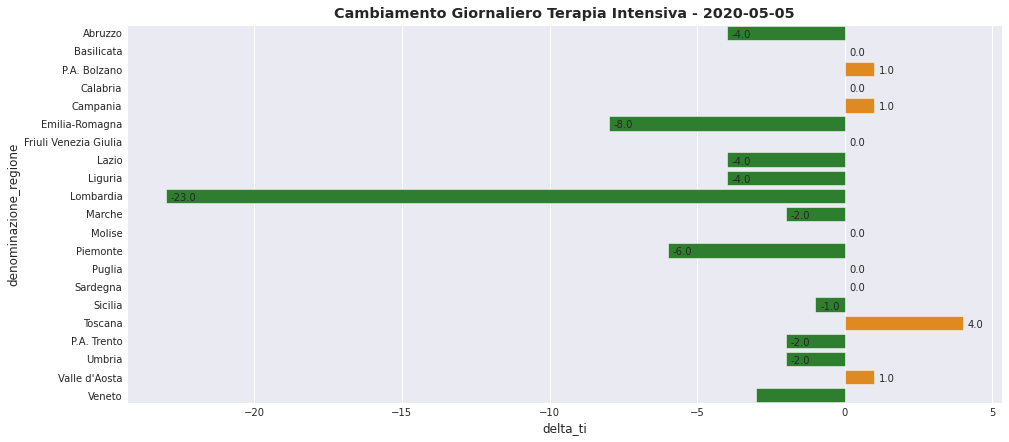

In [60]:
plt.figure(figsize=(14,7))
plt.title(f'Cambiamento Giornaliero Terapia Intensiva - {date.today()}', fontweight='bold')
ax=sns.barplot(data = reg_latest, x='delta_ti', y=reg_latest.index.get_level_values(1), color='orange', palette=(reg_latest['delta_ti'] > 0).map({True:'darkorange',False:'forestgreen'}))
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

In [61]:
reg_merged.head()

stato  ...  nuovi_tamponi_x_1000
Regione               ...                      
Lombardia        ITA  ...              0.641613
Liguria          ITA  ...              0.986689
Piemonte         ITA  ...              1.202367
Abruzzo          ITA  ...              1.052929
Emilia-Romagna   ITA  ...              1.286922

[5 rows x 25 columns]

In [0]:
# Percentage of cases in hospital



reg_merged['perc_ospedalizzati'] = ((reg_merged.totale_ospedalizzati/reg_merged.totale_positivi)*100).round(1)
reg_merged['perc_ti'] = ((reg_merged.terapia_intensiva/reg_merged.totale_positivi)*100).round(1)


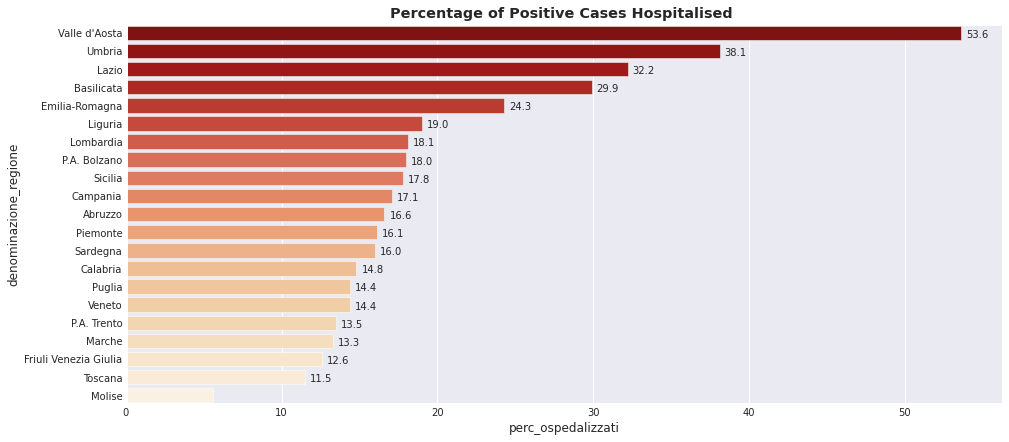

In [63]:
plt.figure(figsize=(14,7))
plt.title('Percentage of Positive Cases Hospitalised ', fontweight='bold')

ax=sns.barplot(data=reg_merged.sort_values(by='perc_ospedalizzati', ascending=False), y='denominazione_regione', x='perc_ospedalizzati', palette='OrRd_r')
for p in ax.patches:
    ax.annotate("%.1f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 10), textcoords='offset points')

### Rolling Mean

In [64]:
regioni.head()

data stato  codice_regione  ... delta_osp  delta_ti  delta_iso
0 2020-02-24 18:00:00   ITA              13  ...       NaN       NaN        NaN
1 2020-02-24 18:00:00   ITA              17  ...       NaN       NaN        NaN
2 2020-02-24 18:00:00   ITA               4  ...       NaN       NaN        NaN
3 2020-02-24 18:00:00   ITA              18  ...       NaN       NaN        NaN
4 2020-02-24 18:00:00   ITA              15  ...       NaN       NaN        NaN

[5 rows x 26 columns]

In [0]:
regioni.reset_index(inplace=True)

In [0]:
regioni['pct_np_ma'] = regioni.groupby('denominazione_regione')['pct_nuovi_pos'].apply(lambda x:x.rolling(center=False,window=5).mean())

In [0]:
regioni['pct_np_ewm'] = regioni.groupby('denominazione_regione')['pct_nuovi_pos'].apply(lambda x:x.ewm(span=8,adjust=False).mean().round(2))

In [68]:
regioni.groupby('denominazione_regione')['deceduti'].apply(lambda x:x.rolling(center=False,window=7).mean())

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1507     861.142857
1508     424.857143
1509      68.142857
1510     137.714286
1511    1495.142857
Name: deceduti, Length: 1512, dtype: float64

In [0]:
subset = regioni[(regioni.denominazione_regione == 'Lombardia') | (regioni.denominazione_regione == 'Veneto') | (regioni.denominazione_regione == 'Toscana') | (regioni.denominazione_regione == 'Campania')]
subset.set_index('data', inplace=True)

In [0]:
start = '2020-03-15'
end = '2020-04-13'

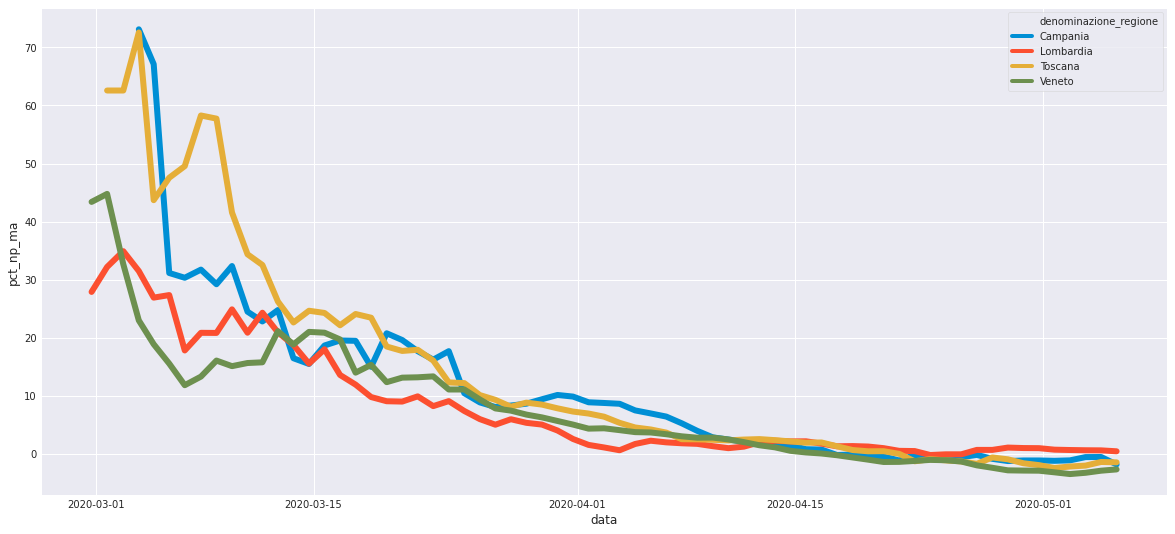

In [71]:


plt.figure(figsize=(18,9))
sns.lineplot(data=subset, x=subset.index, y=subset['pct_np_ma'], hue='denominazione_regione', lw=6)

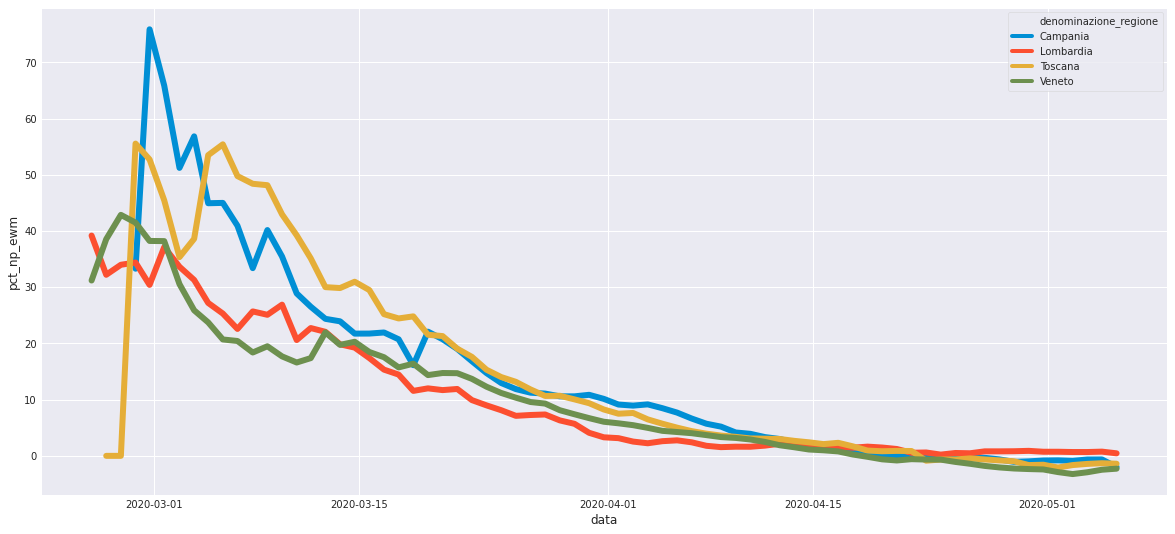

In [72]:

plt.figure(figsize=(18,9))
sns.lineplot(data=subset, x=subset.index, y=subset['pct_np_ewm'], hue='denominazione_regione', lw=6)

In [0]:
regioni.set_index('data', inplace=True)

In [74]:
subtotal_reg.head()

variazione_totale_positivi  ...  pct_deceduti
2020-02-24                           0  ...           NaN
2020-02-25                          90  ...         42.86
2020-02-26                          74  ...         20.00
2020-02-27                         203  ...         41.67
2020-02-28                         233  ...         23.53

[5 rows x 10 columns]

In [0]:
subtotal_reg['MA_deceduti'] = subtotal_reg.nuovi_deceduti.rolling(window=7).mean()

Text(0.5, 1.0, 'Decessi - Media Mobile 7 gg')

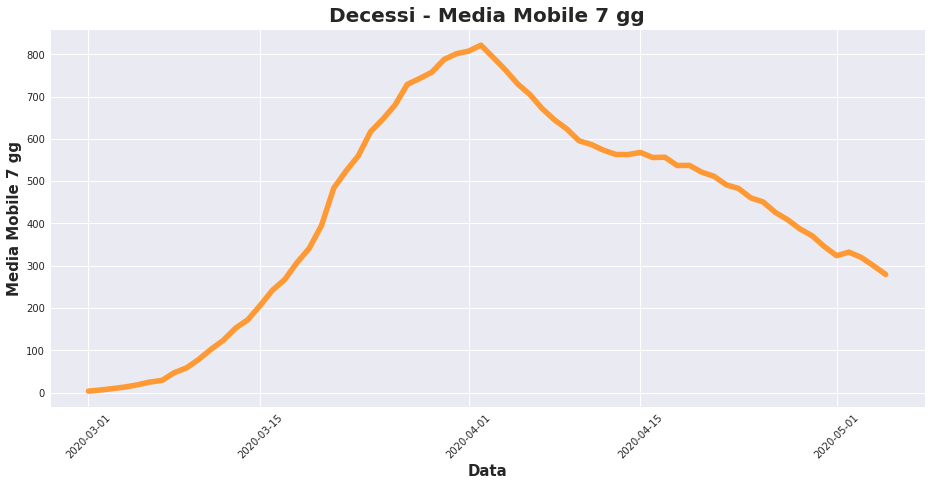

In [76]:
plt.figure(figsize=(14,7))
plt.xticks(rotation=45)
sns.lineplot(data=subtotal_reg,x=subtotal_reg.index, y=subtotal_reg.MA_deceduti, lw=5.5, color='#FF9933')
plt.ylabel('Media Mobile 7 gg', fontdict={'size':15, 'fontweight':'bold'})
plt.xlabel('Data', fontdict={'size':15, 'fontweight':'bold'})
plt.title('Decessi - Media Mobile 7 gg', fontdict={'size':20, 'fontweight':'bold'})

In [0]:
subtotal_reg['MA_positivi'] = subtotal_reg.nuovi_positivi.rolling(window=7).mean()

Text(0.5, 1.0, 'Nuovi Contagi - Media Mobile 7 gg')

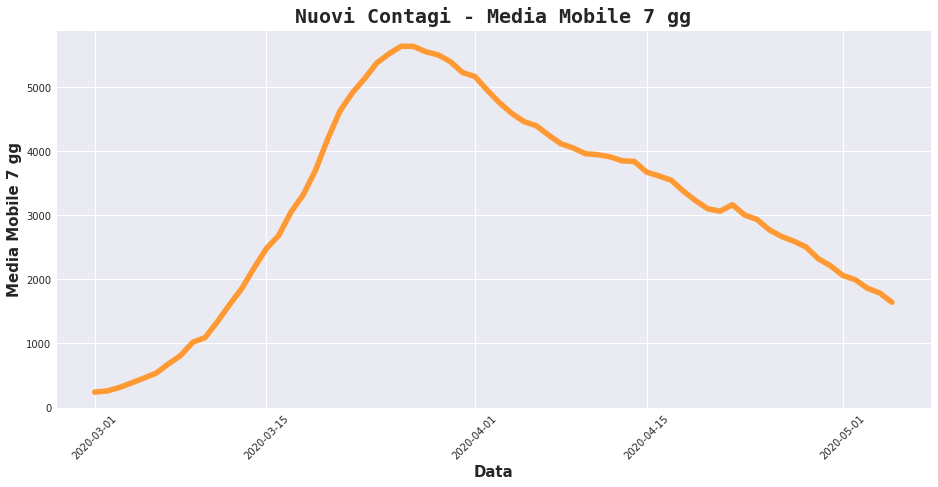

In [78]:
plt.figure(figsize=(14,7))
plt.xticks(rotation=45)
sns.lineplot(data=subtotal_reg,x=subtotal_reg.index, y=subtotal_reg.MA_positivi, lw=5.5, color='#FF9933')
plt.ylabel('Media Mobile 7 gg', fontdict={'size':15, 'fontweight':'bold'})
plt.xlabel('Data', fontdict={'size':15, 'fontweight':'bold'})
plt.title('Nuovi Contagi - Media Mobile 7 gg',fontdict={'size':20, 'fontweight':'bold', 'family':'monospace'} )

### Trials for Ideas

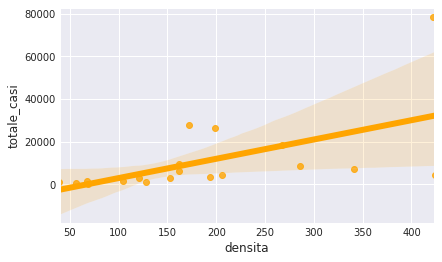

In [79]:

sns.regplot(data=reg_merged, x='densita', y='totale_casi', color='orange')

In [0]:
#pd.read_html('https://it.qwe.wiki/wiki/List_of_Italian_regions_by_GDP#Per_capita_GDP')[0]

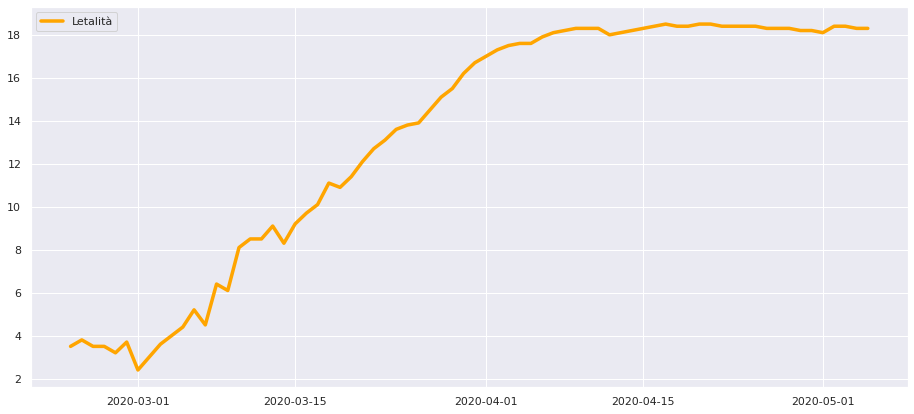

In [81]:
plt.figure(figsize=(14,7))

sns.set()
sns.lineplot(data=lombardia, x=lombardia.index, y=((lombardia.deceduti/lombardia.totale_casi)*100).round(1), color='orange', markers=True, lw=3.5, label='Letalità')


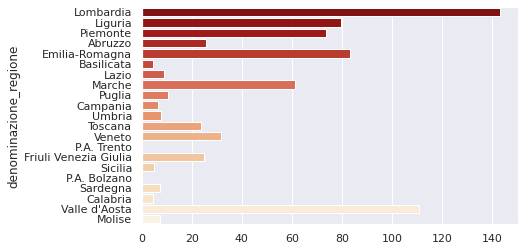

In [82]:
sns.barplot(data=reg_merged, x=((reg_merged.deceduti/reg_merged.Popolazioneresidenti)*100000).round(1).sort_values(ascending=False), y='denominazione_regione', palette='OrRd_r')

In [83]:
prov_latest.head()

stato  codice_regione  ... note_en  pct_crescita
data                                       ...                      
2020-05-05 17:00:00   ITA              13  ...                   0.1
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              13  ...                   1.8
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              17  ...                   1.0

[5 rows x 12 columns]

In [0]:
prov_pop = pd.read_html('https://www.tuttitalia.it/capoluoghi/densita/', thousands='.')[0]

In [85]:
prov_pop.head()

Unnamed: 0    Città  ... Densitàabitanti/km² Altitudinem s.l.m.
0           1   NAPOLI  ...                8059                 17
1           2   MILANO  ...                7589                122
2           3   TORINO  ...                6736                239
3           4  PALERMO  ...                4131                 14
4           5    Monza  ...                3729                162

[5 rows x 8 columns]

In [0]:
prov_pop.rename(columns={prov_pop.columns[1]:'name', prov_pop.columns[6]:'densita'}, inplace=True)

In [0]:
prov_pop.name = prov_pop.name.str.title()

In [0]:
prov_pop.Popolazioneresidenti = pd.to_numeric(prov_pop.Popolazioneresidenti)

In [0]:
prov_pop = prov_pop[['name','densita','Popolazioneresidenti']]

In [0]:
prov_pop.set_index('name', inplace=True)

In [0]:
prov_merged = prov_latest.merge(prov_pop, how='left', left_on='denominazione_provincia', right_on=prov_pop.index)

In [92]:
prov_merged

stato  codice_regione  ... densita  Popolazioneresidenti
0     ITA              13  ...   850.0               50646.0
1     ITA              13  ...   147.0               69478.0
2     ITA              13  ...  3472.0              119297.0
3     ITA              13  ...   356.0               54343.0
4     ITA              17  ...   154.0               60404.0
..    ...             ...  ...     ...                   ...
102   ITA               5  ...   470.0               51104.0
103   ITA               5  ...  1529.0               84999.0
104   ITA               5  ...   626.0              260520.0
105   ITA               5  ...  1297.0              257993.0
106   ITA               5  ...  1375.0              110790.0

[107 rows x 14 columns]

In [0]:
prov_merged.dropna(how='any', inplace=True)

In [94]:
fig = px.scatter(prov_merged, x='densita', y='totale_casi',color=prov_merged.totale_casi, size='Popolazioneresidenti', size_max=70, hover_name=prov_merged.denominazione_provincia, height=1000, width=1200,
           text='denominazione_provincia', trendline='ols',color_continuous_scale=px.colors.sequential.Redor)
fig.update_traces(textposition='top center')

In [95]:
reg_merged.head()

stato  codice_regione  ... perc_ospedalizzati  perc_ti
Regione                               ...                            
Lombardia        ITA               3  ...               18.1      1.4
Liguria          ITA               7  ...               19.0      2.0
Piemonte         ITA               1  ...               16.1      1.0
Abruzzo          ITA              13  ...               16.6      0.6
Emilia-Romagna   ITA               8  ...               24.3      2.2

[5 rows x 27 columns]

In [0]:
#reg_merged.drop(columns=['note_it', 'note_en'], axis=1, inplace=True)

In [0]:
#reg_merged.drop(['note_it','note_en'], axis=1, inplace=True)

In [0]:
reg_merged.dropna(how='any',inplace=True)

In [0]:
ex_lom = reg_merged[reg_merged.denominazione_regione != 'Lombardia']

In [100]:
ex_lom

stato  codice_regione  ... perc_ospedalizzati  perc_ti
Regione                                      ...                            
Liguria                 ITA               7  ...               19.0      2.0
Piemonte                ITA               1  ...               16.1      1.0
Abruzzo                 ITA              13  ...               16.6      0.6
Emilia-Romagna          ITA               8  ...               24.3      2.2
Basilicata              ITA              17  ...               29.9      1.7
Lazio                   ITA              12  ...               32.2      2.1
Marche                  ITA              11  ...               13.3      1.3
Puglia                  ITA              16  ...               14.4      1.3
Campania                ITA              15  ...               17.1      1.0
Umbria                  ITA              10  ...               38.1      6.2
Toscana                 ITA               9  ...               11.5      2.1
Veneto                  ITA               5  ...               14.4      1.4
Friuli Venezia Giulia   ITA               6  ...               12.6      0.4
Sicilia                 ITA              19  ...               17.8      1.2
Sardegna                ITA              20  ...               16.0      1.4
Calabria                ITA              18  ...               14.8      0.6
Valle d'Aosta           ITA               2  ...               53.6      2.7
Molise                  ITA              14  ...                5.6      0.6

[18 rows x 27 columns]

In [101]:
fig = px.scatter(ex_lom, x='densita', y='totale_casi',color=ex_lom.totale_ospedalizzati, size='Popolazioneresidenti',
           hover_name=ex_lom.denominazione_regione, height=1000, width=1200,
           text='denominazione_regione', labels={'densita':'Pop Density - (ppl/km2)', 'totale_ospedalizzati':'Hospitalised Cases','totale_casi':'Total Cases'}, title='Pop Density/Total Cases & Hospitalisation -Excl. Lombardy (Dots Size = Pop Size ) - Ex Lombardy',
           color_continuous_scale=px.colors.sequential.Redor, trendline='ols')
fig.update_traces(textposition='top center')
#pio.write_html(fig, file='prova_density.html', auto_open=True)

In [0]:
#gdp = pd.read_html('https://it.qwe.wiki/wiki/List_of_Italian_regions_by_GDP')[0]
#gdp

In [0]:
#gdp.drop(labels=['Lombardy'], axis=0)

In [0]:
distances = {"Valle d'Aosta":237, 'Piemonte':215, 'Liguria':250, 'Veneto':210, 'Friuli Venezia Giulia':356, 'Emilia-Romagna':219, 
             'Marche':436, 'Toscana':314, 'Umbria':496, 'Lazio':628, 'Abruzzo':643, 'Campania':799, 'Molise':745, 'Puglia':945, 'Basilicata':897, 'Sicilia':1470, 'Sardegna':743,'Calabria':1094}

In [105]:
ex_lom['distanza_lom_km'] = ex_lom.denominazione_regione.map(distances)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
ex_lom.head(3)

stato  codice_regione  ... perc_ti  distanza_lom_km
Regione                         ...                         
Liguria    ITA               7  ...     2.0              250
Piemonte   ITA               1  ...     1.0              215
Abruzzo    ITA              13  ...     0.6              643

[3 rows x 28 columns]

In [107]:
fig = px.scatter(ex_lom, x='distanza_lom_km', y='totale_casi',color=ex_lom.totale_ospedalizzati, size='Popolazioneresidenti',
           hover_name=ex_lom.denominazione_regione, height=1000, width=1200,
           text='denominazione_regione', labels={'distanza_lom_km':'Distance from Lombardy - Centroids, KM', 'totale_ospedalizzati':'Hospitalised Cases','totale_casi':'Total Cases'}, title='Distance from Lombardy/Total Cases & Hospitalisation (Dots Size = Pop Size )',
           color_continuous_scale=px.colors.sequential.Peach, trendline='ols')
fig.update_traces(textposition='top center')

In [108]:
prov_latest.head()

stato  codice_regione  ... note_en  pct_crescita
data                                       ...                      
2020-05-05 17:00:00   ITA              13  ...                   0.1
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              13  ...                   1.8
2020-05-05 17:00:00   ITA              13  ...                   0.0
2020-05-05 17:00:00   ITA              17  ...                   1.0

[5 rows x 12 columns]

In [0]:
geo = prov_latest[['denominazione_provincia','lat','long']]

In [0]:
dist = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/geo.csv', usecols=['denominazione_provincia','Distance'])
dist.set_index('denominazione_provincia', inplace=True)

In [0]:
dist.Distance = dist.Distance.str.rstrip('km')
dist.Distance = pd.to_numeric(dist.Distance)

In [112]:
prov_merged.head(2)

stato  codice_regione  ... densita  Popolazioneresidenti
0   ITA              13  ...   850.0               50646.0
1   ITA              13  ...   147.0               69478.0

[2 rows x 14 columns]

In [113]:
prov_dist = prov_merged.merge(dist, how='left', left_on='denominazione_provincia', right_index=True)
prov_dist.head()

stato  codice_regione  ... Popolazioneresidenti  Distance
0   ITA              13  ...              50646.0    498.93
1   ITA              13  ...              69478.0    454.45
2   ITA              13  ...             119297.0    493.22
3   ITA              13  ...              54343.0    447.75
4   ITA              17  ...              60404.0    774.86

[5 rows x 15 columns]

In [0]:
prov_dist = prov_dist[prov_dist.denominazione_regione != 'Lombardia']

In [115]:
fig = px.scatter(prov_dist, x='Distance', y='totale_casi',color=prov_dist.Distance, size='Popolazioneresidenti',
           hover_name=prov_dist.denominazione_provincia, height=1000, width=1200,
           text='denominazione_provincia', labels={'Distance':'Distance from Lodi, KM', 'totale_ospedalizzati':'Hospitalised Cases','totale_casi':'Total Cases'}, title='Distance from Lodi/Total Cases - Ex Lombardy (Dots Size = Pop Size )',
           color_continuous_scale=px.colors.sequential.Peach, size_max=40, trendline='ols')
fig.update_traces(textposition='top center')
#pio.write_html(fig, file='prova.html', auto_open=True)

In [116]:
subtotal_reg

variazione_totale_positivi  nuovi_tamponi  ...  MA_deceduti  MA_positivi
2020-02-24                           0            0.0  ...          NaN          NaN
2020-02-25                          90         4299.0  ...          NaN          NaN
2020-02-26                          74          964.0  ...          NaN          NaN
2020-02-27                         203         2427.0  ...          NaN          NaN
2020-02-28                         233         3681.0  ...          NaN          NaN
...                                ...            ...  ...          ...          ...
2020-05-01                        -608        74208.0  ...   323.857143  2062.000000
2020-05-02                        -239        55412.0  ...   332.285714  1996.714286
2020-05-03                        -525        44935.0  ...   320.000000  1863.142857
2020-05-04                        -199        37631.0  ...   300.285714  1789.142857
2020-05-05                       -1513        55263.0  ...   279.428571  1644.000000

[72 rows x 12 columns]

In [0]:
prov_dist['casi_1000'] = (prov_dist.totale_casi/prov_dist.Popolazioneresidenti)*1000

In [118]:
prov_dist[prov_dist.denominazione_regione == 'Lombardia']

Empty DataFrame
Columns: [stato, codice_regione, denominazione_regione, codice_provincia, denominazione_provincia, sigla_provincia, lat, long, totale_casi, note_it, note_en, pct_crescita, densita, Popolazioneresidenti, Distance, casi_1000]
Index: []

In [119]:
fig = px.scatter(prov_dist, x='Distance', y='casi_1000',color=prov_dist.densita, size='Popolazioneresidenti',
           hover_name=prov_dist.denominazione_provincia, height=800, width=1200,
           text='denominazione_provincia', labels={'Distance':'Distance from Lodi, KM', 'densita':'Densita ppl/km2','casi_1000':'Cases x 1000 Inhabitants'}, title='Cases x 1000 Inhabitants/Distance from Lodi - Excl. Lombardy  (Dots Size = Pop Size)',
           color_continuous_scale=px.colors.sequential.Peach, size_max=40, trendline='lowess')
fig.update_traces(textposition='top center')

In [120]:
ex_lom['casi_1000'] = (ex_lom.totale_casi/ex_lom.Popolazioneresidenti)*1000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
fig = px.scatter(ex_lom, x='distanza_lom_km', y='casi_1000',color=ex_lom.totale_ospedalizzati, size='Popolazioneresidenti',
           hover_name=ex_lom.denominazione_regione, height=800, width=1200,
           text='denominazione_regione', labels={'distanza_lom_km':'Distance from Lombardy - Centroids, KM', 'totale_ospedalizzati':'Hospitalised Cases','casi_1000':'Cases x 1000 Inhabitants'}, title='Distance from Lombardy / Cases x 1000 Inhabitants & Hospitalisation (Dots Size = Pop Size )',
           color_continuous_scale=px.colors.sequential.Peach, trendline='ols')
fig.update_traces(textposition='top center')

In [122]:
len(subtotal_reg.index)

72

In [123]:
(subtotal_reg.pct_crescita.sum())/len(subtotal_reg)

10.578194444444444

In [124]:
px.scatter_3d(ex_lom, x='distanza_lom_km', y='casi_1000', z='totale_ospedalizzati',color=ex_lom.totale_ospedalizzati, size='Popolazioneresidenti',
           hover_name=ex_lom.denominazione_regione, height=800, width=1000,
           text='denominazione_regione')


### Prophet Time Series Forecasts

In [125]:
subtotal_reg.head(3)

variazione_totale_positivi  nuovi_tamponi  ...  MA_deceduti  MA_positivi
2020-02-24                           0            0.0  ...          NaN          NaN
2020-02-25                          90         4299.0  ...          NaN          NaN
2020-02-26                          74          964.0  ...          NaN          NaN

[3 rows x 12 columns]

In [126]:
sub_for = subtotal_reg[['nuovi_positivi']]
sub_for.reset_index(inplace=True)
sub_for.rename(columns={'index':'ds','nuovi_positivi':'y'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
m = Prophet(changepoint_prior_scale=0.8)
m.fit(sub_for)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [128]:
future = m.make_future_dataframe(periods=20)
future.tail()

ds
87 2020-05-21
88 2020-05-22
89 2020-05-23
90 2020-05-24
91 2020-05-25

In [129]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail().round(0)

ds    yhat  yhat_lower  yhat_upper
87 2020-05-21  -126.0     -1696.0      1612.0
88 2020-05-22  -219.0     -1887.0      1696.0
89 2020-05-23  -121.0     -2072.0      2013.0
90 2020-05-24  -562.0     -2612.0      1733.0
91 2020-05-25 -1198.0     -3379.0      1296.0

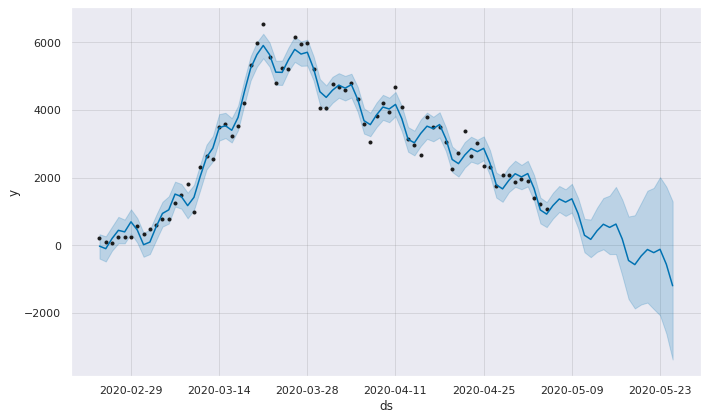

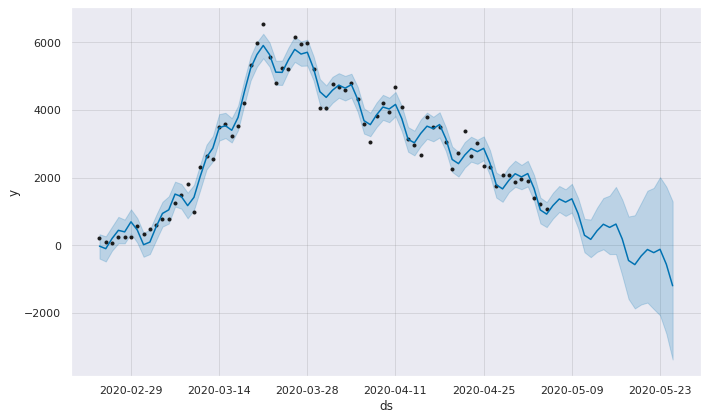

In [130]:
m.plot(forecast)

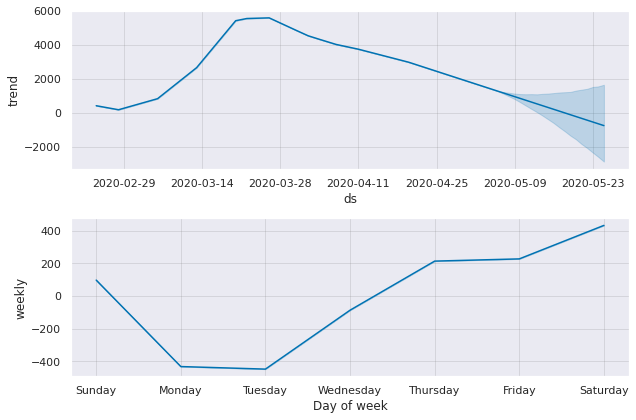

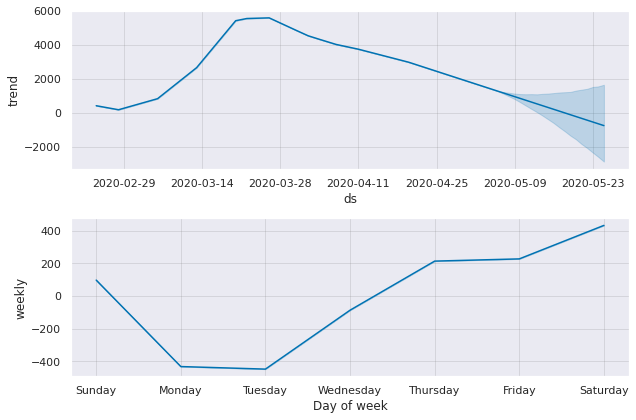

In [131]:
m.plot_components(forecast)

In [132]:
fig = plot_plotly(m, forecast, ylabel='New Cases')
py.iplot(fig)
#pio.write_html(fig, file='prophet_covidita.html', auto_open=True)